## Read the Data

In [2]:
import pandas as pd
fp = "../../../data/producer_price_index.csv"
df = pd.read_csv(fp)

## Basic Data Reorganization
The dataset is clean, just converting the data types to the appropriate values and then renaming the columns to names that made sense to me.

In [3]:
df["DATE"] = pd.to_datetime(df["DATE"])

In [4]:
df.columns = ["Date", "PPI"]

## Run SSA
Run singular spectrum analysis with a window length of 12. This time series has monthly values of the PPI. So the idea with SSA decomposition is to get the dynamics of the evolution of the time series with a yearly window (window_size = 12). The groups parameter gives you the decomposed components of the time series. As you will see, the first component captures the trend and some oscilations of low frequency that dampen with time. The second component captures a high frequency oscillation. A Fourier analysis of the second component will yield the specific harmonics (regular wave behavior). The third component is clearly noise, so there is really no need to explore beyond the second component. The first component explains most the variation in the time series, the second some, the third almost nothing and so on.

In [5]:
from pyts.decomposition import SingularSpectrumAnalysis

In [6]:
transformer = SingularSpectrumAnalysis(window_size=12, groups=4)

In [7]:
X = df["PPI"].values.T.reshape(1, df.shape[0])

In [8]:
X_new = transformer.transform(X)

In [9]:
X_new.shape

(1, 4, 181)

In [10]:
n_timestamps = df.shape[0]
x_time = [ (i+1) for i in range(n_timestamps)]

## Original Timeseries Profile

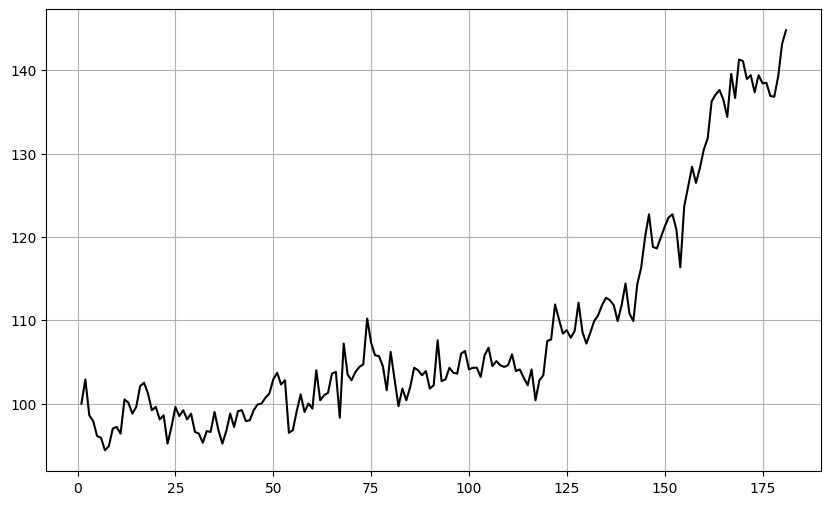

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))
plt.plot(x_time, df["PPI"].values, color="black")
plt.grid()

## First SSA component
This explains most of the variation. There is some oscillation to begin with, but gets dampened out subsequently.

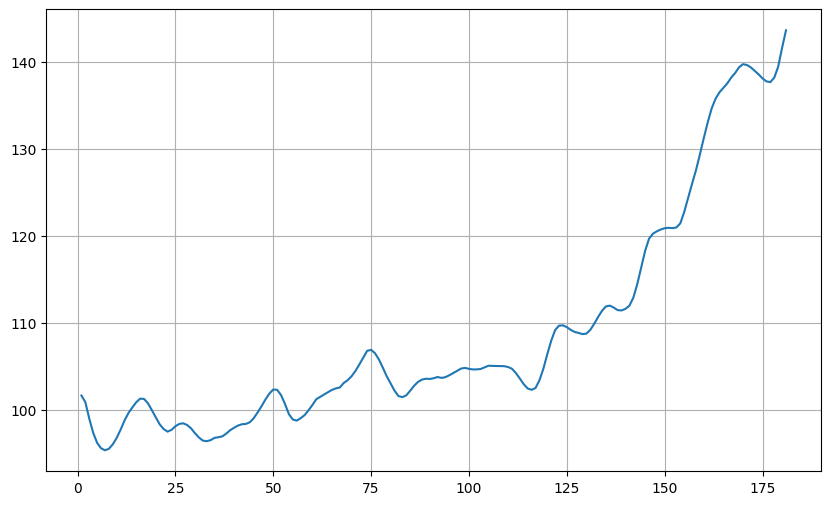

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))
plt.plot(x_time, X_new[0,0,:], color="tab:blue")
plt.grid()

## The second SSA component
Shows primarily the high frequency oscillatory component of the series. Profile this component with Fourier analysis for harmonics information. Note the amplitude values to get an intuition of why this does not explain much variation. The PPI is set to a 100 as the first value of the series. Compare the values on the y axis of the first and second components to get a sense of the variation explained by these components.

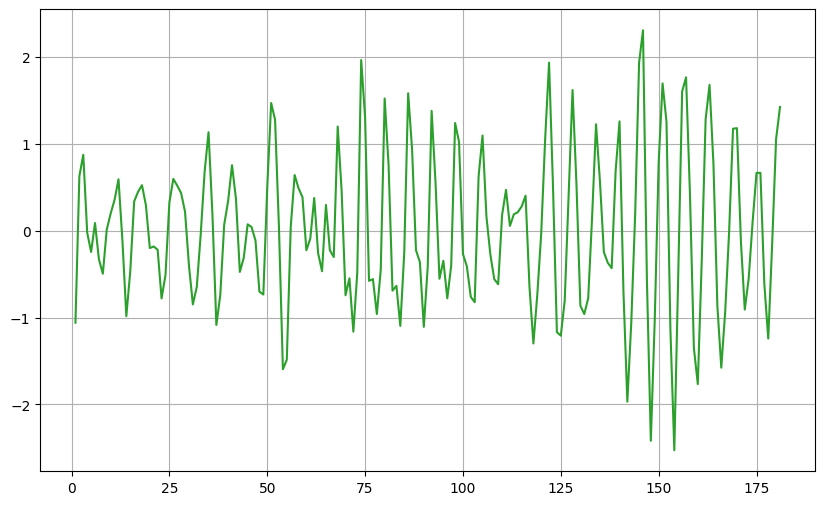

In [13]:
plt.figure(figsize=(10,6))
plt.plot(x_time, X_new[0,1,:], color="tab:green")
plt.grid()

## The noise component
An inspection of the y axis values provides a measure of the variation that this component explains.

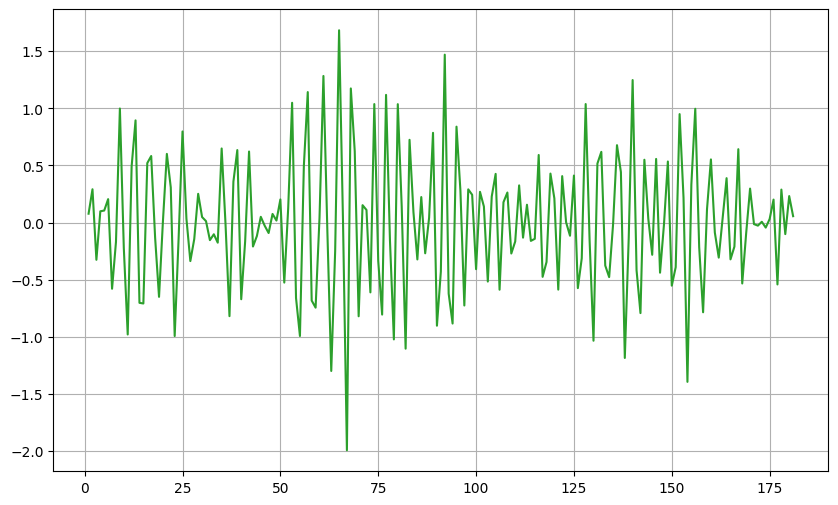

In [14]:
plt.figure(figsize=(10,6))
plt.plot(x_time, X_new[0,2,:], color="tab:green")
plt.grid()

In [15]:
from kmds.ontology.kmds_ontology import *
from kmds.tagging.tag_types import ExploratoryTags

kaw = KnowledgeExtractionExperimentationWorkflow("sba_7a_loan_chargeoff_modelling", namespace=onto)

In [23]:
df_trend = pd.DataFrame.from_records({"Date": df["Date"],"PPI": X_new[0,0,:]})
fp_trend = "../../../data/producer_price_index_ssa_trend.parquet"
df_trend.to_parquet(fp_trend, index=False)

In [24]:
df_osc = pd.DataFrame.from_records({"Date": df["Date"],"PPI": X_new[0,1,:]})
fp_osc = "../../../data/producer_price_index_ssa_osc.parquet"
df_osc.to_parquet(fp_trend, index=False)

In [27]:
exp_obs_list = []
observation_count :int = 1
e1 = ExploratoryObservation(namespace=onto)
e1.finding = "Decomposition done with a yearly time window shows a trend component that explains most of the variation\
There is some oscillatory behavior that dampens out quickly with time. The data file, producer_price_index_ssa_trend.parquet,\
in the repository has the trend data"
e1.finding_sequence = observation_count
e1.exploratory_observation_type = ExploratoryTags.RELEVANCE_OBSERVATION.value
exp_obs_list.append(e1)

In [28]:
observation_count += 1
e2 = ExploratoryObservation(namespace=onto)
e2.finding = "A high frequency oscillatory component was also identified. The specific harmonics can be extracted through\
a Fourier analysis of this component. The data file, producer_price_index_ssa_osc.parquet, has the oscillatory component data."
e2.finding_sequence = observation_count
e2.exploratory_observation_type = ExploratoryTags.RELEVANCE_OBSERVATION.value
exp_obs_list.append(e2)

In [29]:
kaw.has_exploratory_observations = exp_obs_list
from owlready2 import *
KNOWLEDGE_BASE = "data_profile_producer_price_index.xml"
onto.save(file=KNOWLEDGE_BASE, format="rdfxml")